In [1]:
import saflow
from saflow.data import load_fooof_data, load_subjlevel_fooofs, balance_data
from saflow.utils import grid_topoplot
import os.path as op
from saflow.stats import subject_contrast, singlefeat_classif, mask_pvals, apply_tmax
from saflow.utils import get_meg_picks_and_info
import numpy as np
import pickle as pkl
from statsmodels.stats.multitest import fdrcorrection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
picks, chan_info = get_meg_picks_and_info('12', '02')

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.


In [29]:
feature = 'fooof_fixed_1022_sensor_8trials'
feature_fpath = op.join(saflow.BIDS_PATH, 'derivatives', feature)
classif = 'INOUT_2575'
trial_type_to_get = ['correct_commission']
trial_type_formatted = '-'.join(trial_type_to_get)


alpha = 0.05
n_perms = 1

# Fig. 1
Subject-averaged oscillations :
- SA PSD t
- SA PSD LDA
- SA PSDc t
- SA PSDc LDA

# Fig. 2
Aperiodic parameters
- Aper t
- Aper LDA

In [30]:
# Load subject-level data
X_raw, X_corrected, X_model, X_aperiodic, y_subjlevel, groups_subjlevel = load_subjlevel_fooofs(feature, feature_fpath, zscored=False)
X_raw = X_raw[1:,:,:]
X_corrected = X_corrected[1:,:,:]
X_aperiodic = X_aperiodic[1:,:,:]

(7, 62, 270)

In [32]:
# Compute contrasts
raw_contrast, raw_tvals, raw_pvals = subject_contrast(X_raw, y_subjlevel)
corrected_contrast, corrected_tvals, corrected_pvals = subject_contrast(X_corrected, y_subjlevel)
aperiodic_contrast, aperiodic_tvals, aperiodic_pvals = subject_contrast(X_aperiodic, y_subjlevel)


# Classif PSD
classif_name = f'lda_{classif}_{feature}_raw_{trial_type_formatted}_{n_perms}perms_subjlevel'
output_filename = f'../tmp/{classif_name}.pkl'
if not op.exists(output_filename):
    raw_results = singlefeat_classif(LinearDiscriminantAnalysis(), LeaveOneGroupOut(), X_raw, y_subjlevel, groups_subjlevel, n_perms=n_perms)
    with open(output_filename, 'wb') as f:
        pkl.dump(raw_results, f)
else:
    with open(output_filename, 'rb') as f:
        raw_results = pkl.load(f)

# Classif PSD corrected
classif_name = f'lda_{classif}_{feature}_corrected_{trial_type_formatted}_{n_perms}perms_subjlevel'
output_filename = f'../tmp/{classif_name}.pkl'
if not op.exists(output_filename):
    corrected_results = singlefeat_classif(LinearDiscriminantAnalysis(), LeaveOneGroupOut(), X_corrected, y_subjlevel, groups_subjlevel, n_perms=n_perms)
    with open(output_filename, 'wb') as f:
        pkl.dump(corrected_results, f)
else:
    with open(output_filename, 'rb') as f:
        corrected_results = pkl.load(f)

# Classif Aperiodic
classif_name = f'lda_{classif}_{feature}_aperiodic_{trial_type_formatted}_{n_perms}perms_subjlevel'
output_filename = f'../tmp/{classif_name}.pkl'
if not op.exists(output_filename):
    aperiodic_results = singlefeat_classif(LinearDiscriminantAnalysis(), LeaveOneGroupOut(), X_aperiodic, y_subjlevel, groups_subjlevel, n_perms=n_perms)
    with open(output_filename, 'wb') as f:
        pkl.dump(aperiodic_results, f)
else:
    with open(output_filename, 'rb') as f:
        aperiodic_results = pkl.load(f)

Computed feature 0 chan 0 Score 0.5, pvalue 0.5
Computed feature 0 chan 1 Score 0.532258064516129, pvalue 0.5
Computed feature 0 chan 2 Score 0.5, pvalue 1.0
Computed feature 0 chan 3 Score 0.5, pvalue 1.0
Computed feature 0 chan 4 Score 0.5161290322580645, pvalue 0.5
Computed feature 0 chan 5 Score 0.4838709677419355, pvalue 1.0
Computed feature 0 chan 6 Score 0.5161290322580645, pvalue 0.5
Computed feature 0 chan 7 Score 0.5161290322580645, pvalue 0.5
Computed feature 0 chan 8 Score 0.5, pvalue 1.0
Computed feature 0 chan 9 Score 0.5, pvalue 1.0
Computed feature 0 chan 10 Score 0.46774193548387094, pvalue 1.0
Computed feature 0 chan 11 Score 0.5, pvalue 1.0
Computed feature 0 chan 12 Score 0.4838709677419355, pvalue 1.0
Computed feature 0 chan 13 Score 0.5161290322580645, pvalue 1.0
Computed feature 0 chan 14 Score 0.5, pvalue 1.0
Computed feature 0 chan 15 Score 0.532258064516129, pvalue 0.5
Computed feature 0 chan 16 Score 0.532258064516129, pvalue 0.5
Computed feature 0 chan 17 Sc

In [33]:
# Correct pvals raw
raw_qvals = np.array([fdrcorrection(raw_pvals[x,:])[1] for x in range(raw_pvals.shape[0])])
raw_pvals_masks = np.array([mask_pvals(raw_pvals[x,:], alpha) for x in range(raw_pvals.shape[0])])
raw_tmax_pvals = apply_tmax(raw_results)
raw_tmax_pvals_masks = np.array([mask_pvals(raw_tmax_pvals[x,:], alpha) for x in range(raw_tmax_pvals.shape[0])])

# Correct pvals corrected
corrected_qvals = np.array([fdrcorrection(corrected_pvals[x,:])[1] for x in range(corrected_pvals.shape[0])])
corrected_pvals_masks = np.array([mask_pvals(corrected_pvals[x,:], alpha) for x in range(corrected_pvals.shape[0])])
corrected_tmax_pvals = apply_tmax(corrected_results)
corrected_tmax_pvals_masks = np.array([mask_pvals(corrected_tmax_pvals[x,:], alpha) for x in range(corrected_tmax_pvals.shape[0])])

# Correct pvals aperiodic
aperiodic_qvals = np.array([fdrcorrection(aperiodic_pvals[x,:])[1] for x in range(aperiodic_pvals.shape[0])])
aperiodic_pvals_masks = np.array([mask_pvals(aperiodic_pvals[x,:], alpha) for x in range(aperiodic_pvals.shape[0])])
aperiodic_tmax_pvals = apply_tmax(aperiodic_results)
aperiodic_tmax_pvals_masks = np.array([mask_pvals(aperiodic_tmax_pvals[x,:], alpha) for x in range(aperiodic_tmax_pvals.shape[0])])


masks = np.array([raw_pvals_masks, raw_tmax_pvals_masks, corrected_pvals_masks, corrected_tmax_pvals_masks])
masks_aperiodic = np.array([aperiodic_pvals_masks, aperiodic_tmax_pvals_masks])

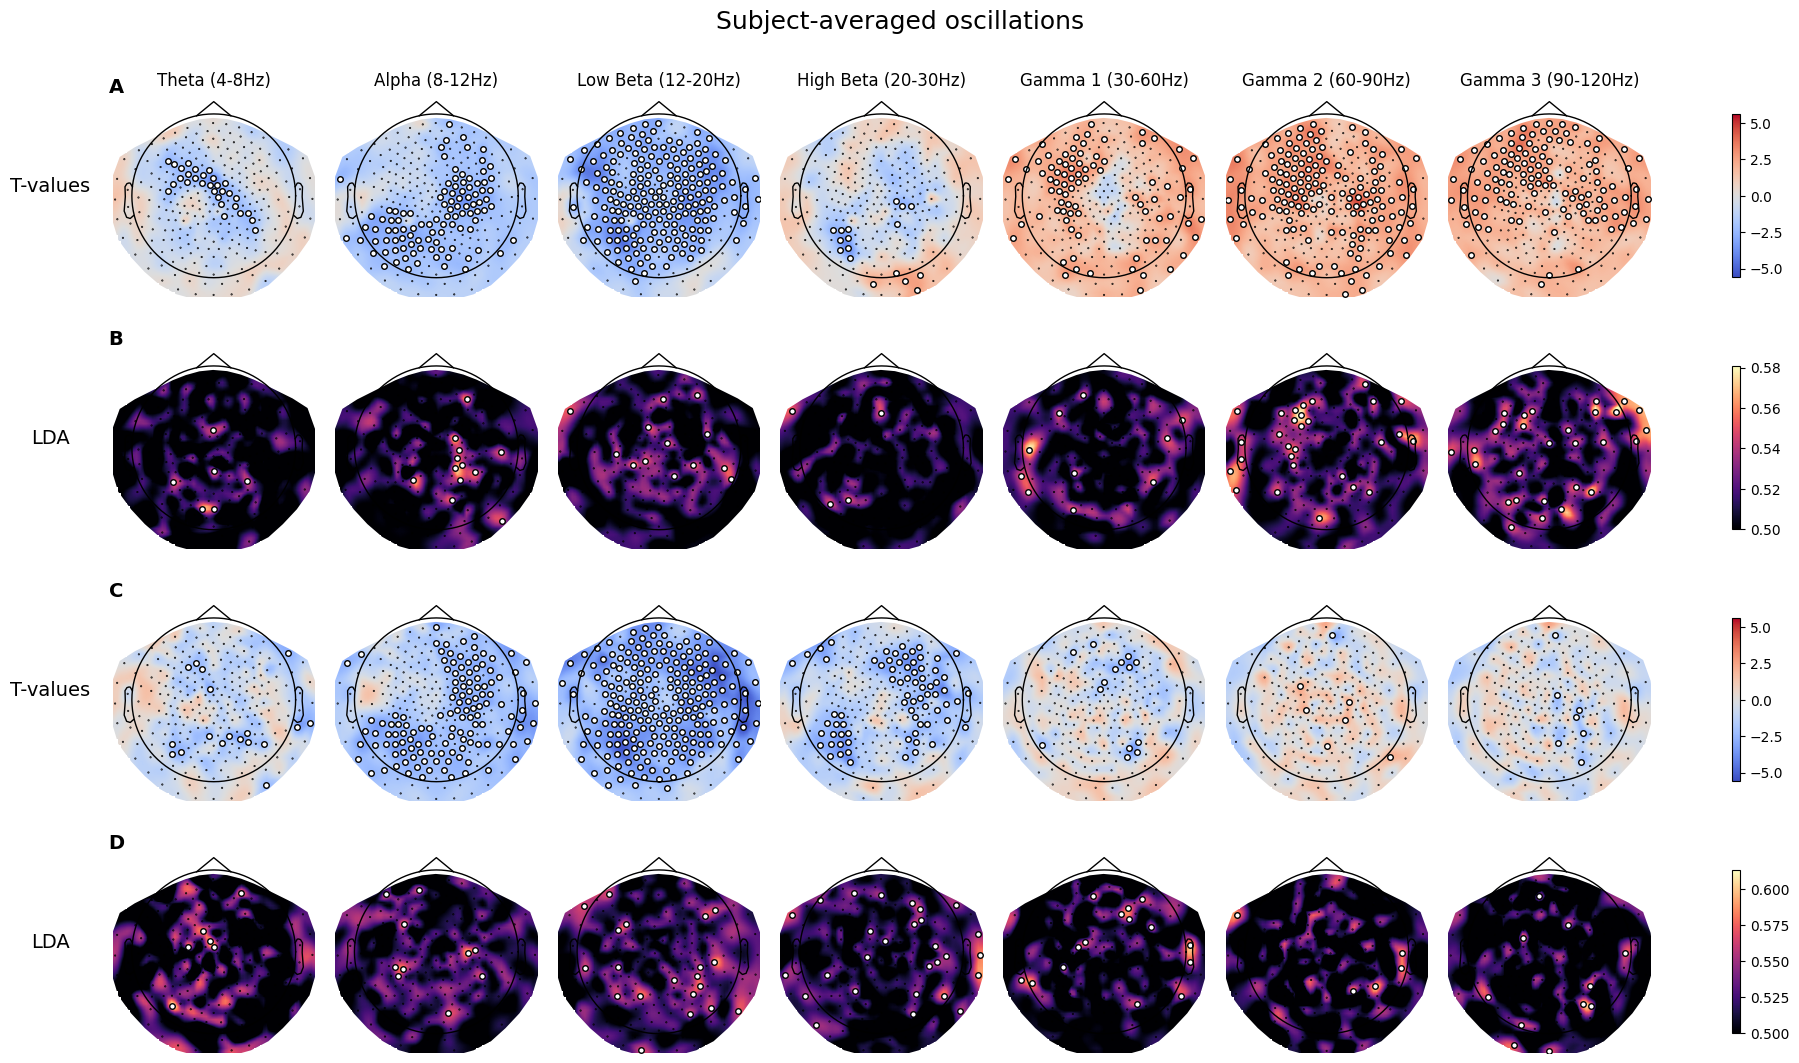

In [34]:
# Fig. 1
maxval_tvals = np.max(abs(np.concatenate([raw_tvals, corrected_tvals])))

data = [raw_tvals, 
        raw_results['scores'], 
        corrected_tvals, 
        corrected_results['scores']]

vlims = [(-maxval_tvals, maxval_tvals),
        (0.5, np.max(raw_results['scores'])),
        (-maxval_tvals, maxval_tvals),
        (0.5, np.max(corrected_results['scores']))]

titles_x = ['Theta (4-8Hz)', 'Alpha (8-12Hz)', 
            'Low Beta (12-20Hz)', 'High Beta (20-30Hz)',
            'Gamma 1 (30-60Hz)', 'Gamma 2 (60-90Hz)', 'Gamma 3 (90-120Hz)']

titles_y = ['T-values', 
            'LDA', 
            'T-values', 
            'LDA']

cmap = ['coolwarm', 
        'magma', 
        'coolwarm', 
        'magma']


fig, axes = grid_topoplot(np.array(data), 
                          chan_info, 
                          titles_x=titles_x, 
                          titles_y=titles_y, 
                          masks=masks, 
                          cmap=cmap, 
                          vlims=vlims, 
                          title=f'Subject-averaged oscillations')

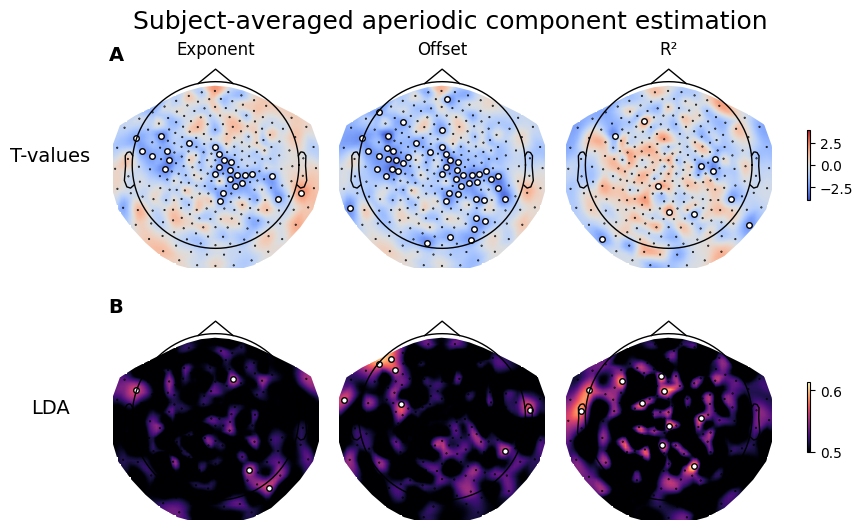

In [35]:
# Fig. 2
maxval_tvals = np.max(abs(aperiodic_tvals))

data = [aperiodic_tvals, 
        aperiodic_results['scores']]

vlims = [(-maxval_tvals, maxval_tvals),
        (0.5, np.max(aperiodic_results['scores']))]

titles_x = ['Exponent', 'Offset', 'R²']

titles_y = ['T-values', 
            'LDA']

cmap = ['coolwarm', 
        'magma']


fig, axes = grid_topoplot(np.array(data), 
                          chan_info, 
                          titles_x=titles_x, 
                          titles_y=titles_y, 
                          masks=masks_aperiodic, 
                          cmap=cmap, 
                          vlims=vlims, 
                          title=f'Subject-averaged aperiodic component estimation')

# Fig. 3
Single-trial analysis
- ST PSD LDA
- ST PSDc LDA

# Fig. 4
Aperiodic parameters single trial
- ST Aper LDA

(8, 10214, 270)

In [14]:
# Load trial-level data
# Raw PSD
feat_to_get = 'psd_raw'
classif_name = f'{classif}_{feature}_{feat_to_get}_{trial_type_formatted}'
loaded_data_filename = f'../tmp/{classif_name}.pkl'
if not op.exists(loaded_data_filename):
    feature_fpath = op.join(saflow.BIDS_PATH, 'derivatives', feature)
    X_raw, y_raw, groups_raw, VTC_raw, task_raw = load_fooof_data(feature, feature_fpath, feat_to_get, trial_type_to_get, classif=classif)
    with open(loaded_data_filename, 'wb') as f:
        pkl.dump([X_raw, y_raw, groups_raw, VTC_raw, task_raw], f)
else:
    with open(loaded_data_filename, 'rb') as f:
        X_raw, y_raw, groups_raw, VTC_raw, task_raw = pkl.load(f)
# Corrected PSD
feat_to_get = 'psd_corrected'
classif_name = f'{classif}_{feature}_{feat_to_get}_{trial_type_formatted}'
loaded_data_filename = f'../tmp/{classif_name}.pkl'
if not op.exists(loaded_data_filename):
    feature_fpath = op.join(saflow.BIDS_PATH, 'derivatives', feature)
    X_corrected, y_corrected, groups_corrected, VTC_corrected, task_corrected = load_fooof_data(feature, feature_fpath, feat_to_get, trial_type_to_get, classif=classif)
    with open(loaded_data_filename, 'wb') as f:
        pkl.dump([X_corrected, y_corrected, groups_corrected, VTC_corrected, task_corrected], f)
else:
    with open(loaded_data_filename, 'rb') as f:
        X_corrected, y_corrected, groups_corrected, VTC_corrected, task_corrected = pkl.load(f)
# Aperiodic
feat_to_get = 'ksor'
classif_name = f'{classif}_{feature}_{feat_to_get}_{trial_type_formatted}'
loaded_data_filename = f'../tmp/{classif_name}.pkl'
if not op.exists(loaded_data_filename):
    feature_fpath = op.join(saflow.BIDS_PATH, 'derivatives', feature)
    X_aperiodic, y_aperiodic, groups_aperiodic, VTC_aperiodic, task_aperiodic = load_fooof_data(feature, feature_fpath, feat_to_get, trial_type_to_get, classif=classif)
    with open(loaded_data_filename, 'wb') as f:
        pkl.dump([X_aperiodic, y_aperiodic, groups_aperiodic, VTC_aperiodic, task_aperiodic], f)
else:
    with open(loaded_data_filename, 'rb') as f:
        X_aperiodic, y_aperiodic, groups_aperiodic, VTC_aperiodic, task_aperiodic = pkl.load(f)

In [16]:
X_raw = X_raw[1:,:,:]
X_corrected = X_corrected[1:,:,:]
X_aperiodic = X_aperiodic[1:,:,:]

X_raw_bal, y_raw_bal, gr_raw_bal = balance_data(X_raw,y_raw,groups_raw)
print(f'Data shape before balance (raw) : {X_raw.shape} and after balance : {X_raw_bal.shape}')
X_corrected_bal, y_corrected_bal, gr_corrected_bal = balance_data(X_corrected,y_corrected,groups_corrected)
print(f'Data shape before balance (corrected) : {X_corrected.shape} and after balance : {X_corrected_bal.shape}')
X_aperiodic_bal, y_aperiodic_bal, gr_aperiodic_bal = balance_data(X_aperiodic,y_aperiodic,groups_aperiodic)
print(f'Data shape before balance (aperiodic) : {X_aperiodic.shape} and after balance : {X_aperiodic_bal.shape}')


Subject sub-04 max trials : 36 OUT
36 113
36
Subject sub-05 max trials : 154 IN
154 187
154
Subject sub-06 max trials : 60 OUT
60 93
60
Subject sub-07 max trials : 148 OUT
148 194
148
Subject sub-08 max trials : 30 OUT
40 30
30
Subject sub-09 max trials : 153 IN
180 153
153
Subject sub-10 max trials : 200 IN
200 235
200
Subject sub-11 max trials : 110 OUT
110 159
110
Subject sub-12 max trials : 169 OUT
169 255
169
Subject sub-13 max trials : 139 IN
139 202
139
Subject sub-14 max trials : 216 IN
216 219
216
Subject sub-15 max trials : 9 IN
24 9
9
Subject sub-17 max trials : 215 OUT
215 252
215
Subject sub-18 max trials : 25 OUT
25 54
25
Subject sub-20 max trials : 114 OUT
114 187
114
Subject sub-21 max trials : 317 OUT
321 317
317
Subject sub-22 max trials : 127 OUT
127 233
127
Subject sub-23 max trials : 11 OUT
72 11
11
Subject sub-24 max trials : 114 IN
114 200
114
Subject sub-26 max trials : 251 IN
251 251
251
Subject sub-28 max trials : 258 IN
258 321
258
Subject sub-29 max trials :

In [22]:
# Compute contrasts
raw_contrast, raw_tvals, raw_pvals = subject_contrast(X_raw_bal, y_raw_bal)
corrected_contrast, corrected_tvals, corrected_pvals = subject_contrast(X_corrected_bal, y_corrected_bal)
aperiodic_contrast, aperiodic_tvals, aperiodic_pvals = subject_contrast(X_aperiodic_bal, y_aperiodic_bal)

# Classif PSD
classif_name = f'lda_{classif}_{feature}_raw_{trial_type_formatted}_{n_perms}perms'
output_filename = f'../tmp/{classif_name}.pkl'
if not op.exists(output_filename):
    raw_results = singlefeat_classif(LinearDiscriminantAnalysis(), LeaveOneGroupOut(), X_raw_bal, y_raw_bal, gr_raw_bal, n_perms=n_perms)
    with open(output_filename, 'wb') as f:
        pkl.dump(raw_results, f)
else:
    with open(output_filename, 'rb') as f:
        raw_results = pkl.load(f)

# Classif PSD corrected
classif_name = f'lda_{classif}_{feature}_corrected_{trial_type_formatted}_{n_perms}perms'
output_filename = f'../tmp/{classif_name}.pkl'
if not op.exists(output_filename):
    corrected_results = singlefeat_classif(LinearDiscriminantAnalysis(), LeaveOneGroupOut(), X_corrected_bal, y_corrected_bal, gr_corrected_bal, n_perms=n_perms)
    with open(output_filename, 'wb') as f:
        pkl.dump(corrected_results, f)
else:
    with open(output_filename, 'rb') as f:
        corrected_results = pkl.load(f)

# Classif Aperiodic
classif_name = f'lda_{classif}_{feature}_aperiodic_{trial_type_formatted}_{n_perms}perms'
output_filename = f'../tmp/{classif_name}.pkl'
if not op.exists(output_filename):
    aperiodic_results = singlefeat_classif(LinearDiscriminantAnalysis(), LeaveOneGroupOut(), X_aperiodic_bal, y_aperiodic_bal, gr_aperiodic_bal, n_perms=n_perms)
    with open(output_filename, 'wb') as f:
        pkl.dump(aperiodic_results, f)
else:
    with open(output_filename, 'rb') as f:
        aperiodic_results = pkl.load(f)



Computed feature 0 chan 0 Score 0.5112785601207314, pvalue 0.5
Computed feature 0 chan 1 Score 0.5033822917792201, pvalue 0.5
Computed feature 0 chan 2 Score 0.502057319433559, pvalue 1.0
Computed feature 0 chan 3 Score 0.5004142585256733, pvalue 1.0
Computed feature 0 chan 4 Score 0.5078354974144985, pvalue 0.5
Computed feature 0 chan 5 Score 0.5121540160223319, pvalue 0.5
Computed feature 0 chan 6 Score 0.5205238211491807, pvalue 0.5
Computed feature 0 chan 7 Score 0.48898718958620807, pvalue 1.0
Computed feature 0 chan 8 Score 0.49728368107838444, pvalue 1.0
Computed feature 0 chan 9 Score 0.5022537109629783, pvalue 0.5
Computed feature 0 chan 10 Score 0.49888987406379026, pvalue 0.5
Computed feature 0 chan 11 Score 0.5027097460718329, pvalue 0.5
Computed feature 0 chan 12 Score 0.49650724814590835, pvalue 0.5
Computed feature 0 chan 13 Score 0.5009288421228716, pvalue 1.0
Computed feature 0 chan 14 Score 0.4772447650882822, pvalue 1.0
Computed feature 0 chan 15 Score 0.502291866691

In [23]:
# Correct pvals raw
raw_qvals = np.array([fdrcorrection(raw_pvals[x,:])[1] for x in range(raw_pvals.shape[0])])
raw_pvals_masks = np.array([mask_pvals(raw_pvals[x,:], alpha) for x in range(raw_pvals.shape[0])])
raw_tmax_pvals = apply_tmax(raw_results)
raw_tmax_pvals_masks = np.array([mask_pvals(raw_tmax_pvals[x,:], alpha) for x in range(raw_tmax_pvals.shape[0])])

# Correct pvals corrected
corrected_qvals = np.array([fdrcorrection(corrected_pvals[x,:])[1] for x in range(corrected_pvals.shape[0])])
corrected_pvals_masks = np.array([mask_pvals(corrected_pvals[x,:], alpha) for x in range(corrected_pvals.shape[0])])
corrected_tmax_pvals = apply_tmax(corrected_results)
corrected_tmax_pvals_masks = np.array([mask_pvals(corrected_tmax_pvals[x,:], alpha) for x in range(corrected_tmax_pvals.shape[0])])

# Correct pvals aperiodic
aperiodic_qvals = np.array([fdrcorrection(aperiodic_pvals[x,:])[1] for x in range(aperiodic_pvals.shape[0])])
aperiodic_pvals_masks = np.array([mask_pvals(aperiodic_pvals[x,:], alpha) for x in range(aperiodic_pvals.shape[0])])
aperiodic_tmax_pvals = apply_tmax(aperiodic_results)
aperiodic_tmax_pvals_masks = np.array([mask_pvals(aperiodic_tmax_pvals[x,:], alpha) for x in range(aperiodic_tmax_pvals.shape[0])])


masks = np.array([raw_tmax_pvals_masks, corrected_tmax_pvals_masks])
masks_aperiodic = np.array([aperiodic_tmax_pvals_masks])

In [24]:
corrected_tmax_pvals_masks.shape

(7, 270)

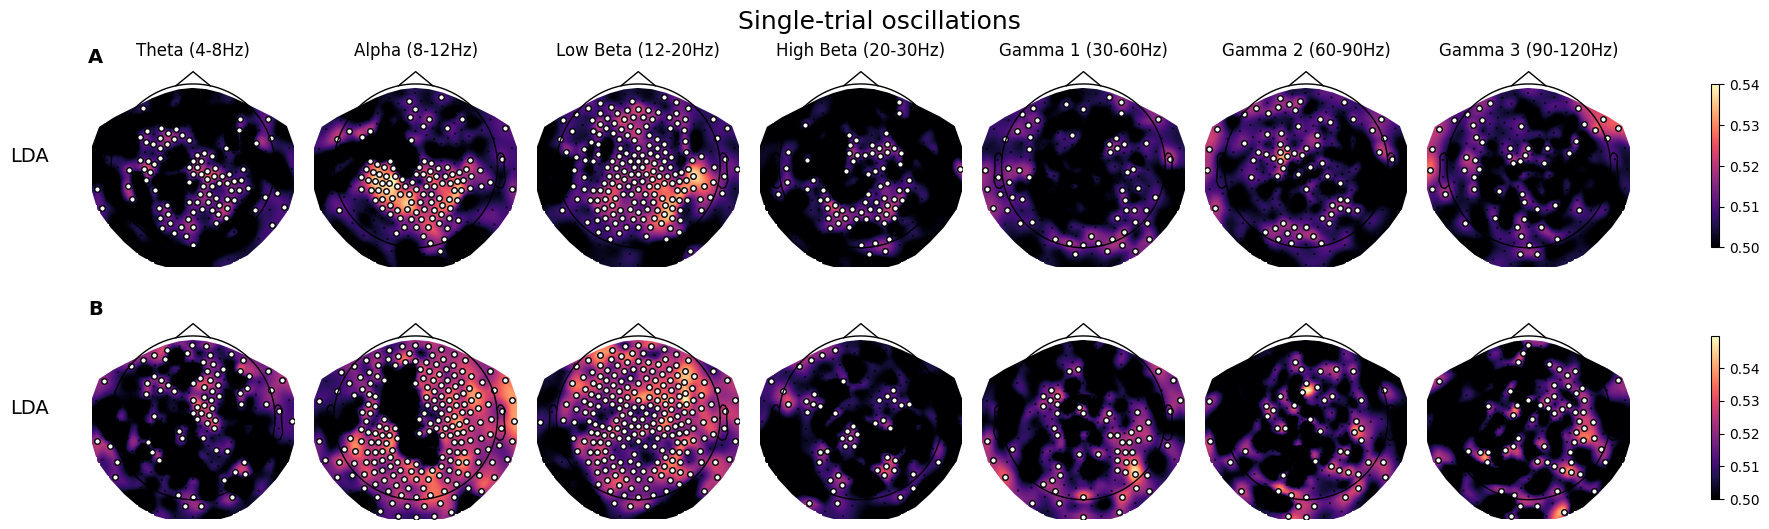

In [25]:
# Fig. 1

data = [raw_results['scores'],  
        corrected_results['scores']]

vlims = [(0.5, np.max(raw_results['scores'])),
        (0.5, np.max(corrected_results['scores']))]

titles_x = ['Theta (4-8Hz)', 'Alpha (8-12Hz)', 
            'Low Beta (12-20Hz)', 'High Beta (20-30Hz)',
            'Gamma 1 (30-60Hz)', 'Gamma 2 (60-90Hz)', 'Gamma 3 (90-120Hz)']

titles_y = ['LDA',
            'LDA']

cmap = ['magma', 
        'magma']


fig, axes = grid_topoplot(np.array(data), 
                          chan_info, 
                          titles_x=titles_x, 
                          titles_y=titles_y, 
                          masks=masks, 
                          cmap=cmap, 
                          vlims=vlims, 
                          title=f'Single-trial oscillations')

In [26]:
# Fig. 2
maxval_tvals = np.max(abs(aperiodic_tvals))

data = np.array(aperiodic_results['scores']).reshape(1,data.shape[0],data.shape[1])

vlims = [(0.5, np.max(aperiodic_results['scores']))]

titles_x = ['Exponent', 'Offset', 'R²']

titles_y = ['LDA']

cmap = [ 'magma']


fig, axes = grid_topoplot(data, 
                          chan_info, 
                          titles_x=titles_x, 
                          titles_y=titles_y, 
                          masks=masks_aperiodic, 
                          cmap=cmap, 
                          vlims=vlims, 
                          title=f'Single-trial aperiodic component estimation')

AttributeError: 'list' object has no attribute 'shape'